In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

from sklearn.metrics import r2_score

import numpy as np

from tqdm import tqdm
from datetime import timedelta  

import warnings
warnings.filterwarnings(action='ignore')

import pandas_profiling as pf

In [68]:
train_data = pd.read_csv("../dataset/train_test/train.csv")
test_data = pd.read_csv("../dataset/train_test/test.csv")

data = pd.concat([train_data, test_data])

In [69]:
data['date'] = pd.to_datetime(data['date'])

In [70]:
data['week'] = data['week'].astype(str)

data_dummies = pd.get_dummies(data)

In [71]:
data_dummies

,date,count,rain,dust,temp,holiday,user,shift1,week_0,week_1,week_2,week_3,week_4,week_5,week_6
0,2017-01-02,3796,0.3,113.974359,5.0,0,182,2307,1,0,0,0,0,0,0
1,2017-01-03,4049,0.0,80.948718,2.0,0,198,3796,0,1,0,0,0,0,0
2,2017-01-04,4646,0.0,58.358974,3.9,0,189,4049,0,0,1,0,0,0,0
3,2017-01-05,4500,0.0,38.769231,3.8,0,190,4646,0,0,0,1,0,0,0
4,2017-01-06,4944,0.0,23.743590,5.4,0,241,4500,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,2020-06-26,96150,2.1,22.653061,21.8,0,3602,46415,0,0,0,0,1,0,0
118,2020-06-27,107001,0.0,26.489796,24.1,0,7049,96150,0,0,0,0,0,1,0
119,2020-06-28,98568,0.0,29.653061,25.2,0,6982,107001,0,0,0,0,0,0,1
120,2020-06-29,70053,11.9,36.469388,23.8,0,2609,98568,1,0,0,0,0,0,0


In [72]:
data['holiday']

0      0
1      0
2      0
3      0
4      0
      ..
117    0
118    0
119    0
120    0
121    0
Name: holiday, Length: 1207, dtype: int64

In [73]:
data_dummies

,date,count,rain,dust,temp,holiday,user,shift1,week_0,week_1,week_2,week_3,week_4,week_5,week_6
0,2017-01-02,3796,0.3,113.974359,5.0,0,182,2307,1,0,0,0,0,0,0
1,2017-01-03,4049,0.0,80.948718,2.0,0,198,3796,0,1,0,0,0,0,0
2,2017-01-04,4646,0.0,58.358974,3.9,0,189,4049,0,0,1,0,0,0,0
3,2017-01-05,4500,0.0,38.769231,3.8,0,190,4646,0,0,0,1,0,0,0
4,2017-01-06,4944,0.0,23.743590,5.4,0,241,4500,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,2020-06-26,96150,2.1,22.653061,21.8,0,3602,46415,0,0,0,0,1,0,0
118,2020-06-27,107001,0.0,26.489796,24.1,0,7049,96150,0,0,0,0,0,1,0
119,2020-06-28,98568,0.0,29.653061,25.2,0,6982,107001,0,0,0,0,0,0,1
120,2020-06-29,70053,11.9,36.469388,23.8,0,2609,98568,1,0,0,0,0,0,0


In [74]:
data.describe()

,count,rain,dust,temp,holiday,user,shift1
count,1207.000000,1207.000000,1207.000000,1207.000000,1207.000000,1207.000000,1207.000000
mean,35299.103563,3.023695,43.122649,12.695443,0.049710,1801.076222,35269.460646
std,28021.377837,11.828668,23.050127,10.737454,0.217435,1698.879689,28037.347402
min,9.000000,0.000000,6.914286,-14.800000,0.000000,32.000000,9.000000
25%,12929.000000,0.000000,27.515306,3.600000,0.000000,493.000000,12920.000000
50%,27500.000000,0.000000,39.260870,13.100000,0.000000,1295.000000,27441.000000
75%,52553.500000,0.200000,53.596410,22.300000,0.000000,2644.000000,52553.500000
max,110377.000000,144.500000,194.820513,33.700000,1.000000,9192.000000,110377.000000


In [75]:
corr = data_dummies.corr(method='pearson')

In [76]:
corr

,count,rain,dust,temp,holiday,user,shift1,week_0,week_1,week_2,week_3,week_4,week_5,week_6
count,1.000000,-0.161142,-0.221183,0.484388,-0.020157,0.765353,0.889188,0.004706,0.018997,0.002022,0.004591,0.015996,0.001525,-0.048193
rain,-0.161142,1.000000,-0.190679,0.162039,-0.003940,-0.130907,-0.031577,0.034930,0.025300,-0.004692,-0.014719,-0.045493,-0.048202,0.052133
dust,-0.221183,-0.190679,1.000000,-0.268750,-0.010311,-0.190161,-0.212329,-0.003929,0.024162,0.006165,-0.027456,0.004109,0.044438,-0.047536
temp,0.484388,0.162039,-0.268750,1.000000,0.004608,0.511898,0.483287,0.001400,0.004156,-0.007110,-0.018112,-0.004761,0.013585,0.010864
holiday,-0.020157,-0.003940,-0.010311,0.004608,1.000000,0.142576,-0.012641,0.024313,0.024313,0.038255,-0.005470,-0.017404,-0.037361,-0.027333
user,0.765353,-0.130907,-0.190161,0.511898,0.142576,1.000000,0.677791,-0.054723,-0.072153,-0.072193,-0.096256,-0.053557,0.175742,0.175793
shift1,0.889188,-0.031577,-0.212329,0.483287,-0.012641,0.677791,1.000000,-0.054533,0.005168,0.022472,0.004033,0.008867,0.018061,-0.003428
week_0,0.004706,0.034930,-0.003929,0.001400,0.024313,-0.054723,-0.054533,1.000000,-0.170708,-0.167859,-0.167859,-0.169001,-0.166714,-0.167859
week_1,0.018997,0.025300,0.024162,0.004156,0.024313,-0.072153,0.005168,-0.170708,1.000000,-0.167859,-0.167859,-0.169001,-0.166714,-0.167859
week_2,0.002022,-0.004692,0.006165,-0.007110,0.038255,-0.072193,0.022472,-0.167859,-0.167859,1.000000,-0.165058,-0.166181,-0.163932,-0.165058


In [30]:
import seaborn as sns

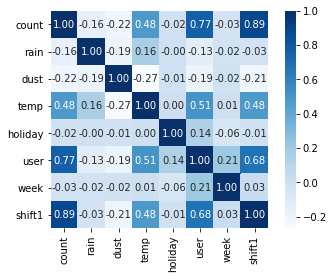

In [34]:
df_heatmap = sns.heatmap(corr, cbar = True, annot = True,  fmt = '.2f', square = True, cmap = 'Blues')

In [11]:
data

,date,count,rain,dust,temp,holiday,user,week,shift1
0,2017-01-02,3796,0.3,113.974359,5.0,0,182,0,2307
1,2017-01-03,4049,0.0,80.948718,2.0,0,198,1,3796
2,2017-01-04,4646,0.0,58.358974,3.9,0,189,2,4049
3,2017-01-05,4500,0.0,38.769231,3.8,0,190,3,4646
4,2017-01-06,4944,0.0,23.743590,5.4,0,241,4,4500
...,...,...,...,...,...,...,...,...,...
117,2020-06-26,96150,2.1,22.653061,21.8,0,3602,4,46415
118,2020-06-27,107001,0.0,26.489796,24.1,0,7049,5,96150
119,2020-06-28,98568,0.0,29.653061,25.2,0,6982,6,107001
120,2020-06-29,70053,11.9,36.469388,23.8,0,2609,0,98568


In [ ]:
train_data = train_data[['date', 'count']]
test_data = test_data[['date', 'count']]

data = pd.concat([train_data, test_data])

data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')

train_data['date'] = pd.to_datetime(train_data['date'])
train_data = train_data.set_index('date')

test_data['date'] = pd.to_datetime(test_data['date'])
test_data = test_data.set_index('date')